# Think Bayes

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint

from thinkbayes2 import MakePoissonPmf, EvalBinomialPmf, MakeMixture

import thinkplot

## Lions and Tigers and Bears

Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are.

During the tour, we see 3 lions, 2 tigers and one bear.  Assuming that every animal had an equal chance to appear in our sample, estimate the prevalence of each species.

What is the probability that the next animal we see is a bear?

### Grid algorithm



In [2]:
class LionsTigersBears(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: string 'L' , 'T', 'B'
        hypo: p1, p2, p3
        """
        p1, p2, p3 = hypo
        prevs = {'L' : p1, 'T': p2, 'B': p3}
        
        return prevs[data]

In [3]:
# Solution goes here

In [33]:
ps = np.linspace(0, 1, 101);

In [5]:
from itertools import product

def enumerate_triples(ps):
    for p1, p2, p3 in product(ps, ps, ps):
        if p1+p2+p3 == 1:
            yield p1, p2, p3

Write a better version of `enumerate_triples` that doesn't run into problems with floating-point.

In [6]:
from itertools import product

def enumerate_triples(ps):
    for p1, p2 in product(ps, ps):
        if p1 + p2 <= 1:
            yield p1, p2, int((1-p1-p2)*101)/101

In [7]:
suite = LionsTigersBears(enumerate_triples(ps));
prior = suite.Copy();

In [8]:
def plot_marginal_pmfs(joint):
    pmf_lion = joint.Marginal(0)
    pmf_tiger = joint.Marginal(1)
    pmf_bear = joint.Marginal(2)

    thinkplot.Pdf(pmf_lion, label='lions')
    thinkplot.Pdf(pmf_tiger, label='tigers')
    thinkplot.Pdf(pmf_bear, label='bears')
    
    thinkplot.decorate(xlabel='Prevalence',
                       ylabel='PMF')

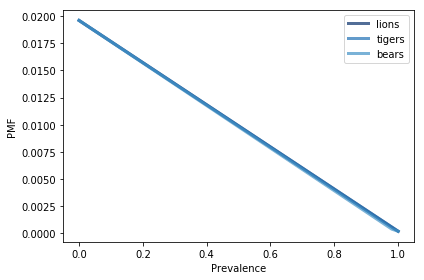

In [9]:
plot_marginal_pmfs(suite)

In [10]:
for data in 'LLLTTB':
    suite.Update(data)

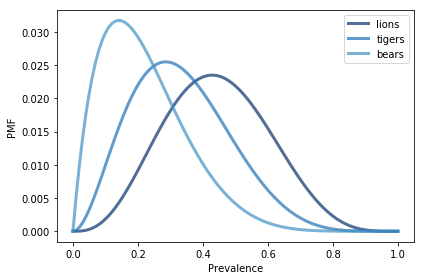

In [11]:
plot_marginal_pmfs(suite)

In [12]:
def plot_marginal_cdfs(joint):
    pmf_lion = joint.Marginal(0)
    pmf_tiger = joint.Marginal(1)
    pmf_bear = joint.Marginal(2)

    thinkplot.Cdf(pmf_lion.MakeCdf(), label='lions')
    thinkplot.Cdf(pmf_tiger.MakeCdf(), label='tigers')
    thinkplot.Cdf(pmf_bear.MakeCdf(), label='bears')
    
    thinkplot.decorate(xlabel='Prevalence',
                       ylabel='CDF')

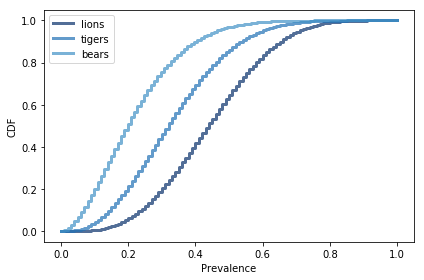

In [13]:
plot_marginal_cdfs(suite)

### Using the Dirichlet object

In [14]:
from thinkbayes2 import Dirichlet

def DirichletMarginal(dirichlet, i):
    return dirichlet.MarginalBeta(i).MakePmf()

Dirichlet.Marginal = DirichletMarginal

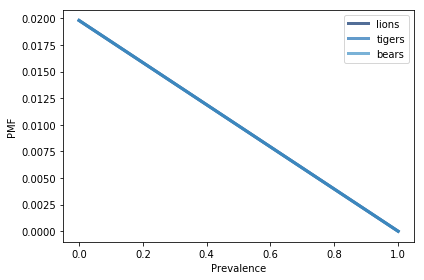

In [15]:
dirichlet = Dirichlet(3)
plot_marginal_pmfs(dirichlet)

In [16]:
dirichlet.Update((3, 2, 1))

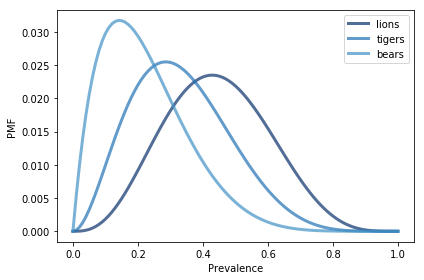

In [17]:
plot_marginal_pmfs(dirichlet)

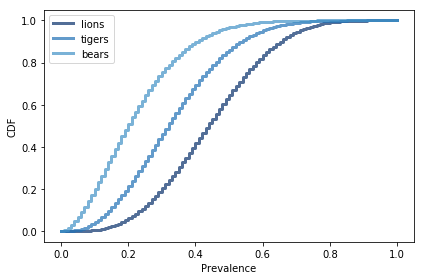

In [18]:
plot_marginal_cdfs(dirichlet)

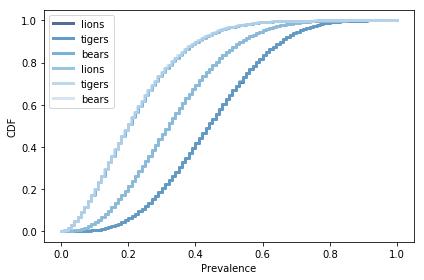

In [19]:
thinkplot.PrePlot(6)
plot_marginal_cdfs(dirichlet)
plot_marginal_cdfs(suite)

### MCMC

Implement this model using MCMC.  You might want to start with [this example](http://christianherta.de/lehre/dataScience/bayesian/Multinomial-Dirichlet.slides.php).

In [20]:
import pymc3 as pm

/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [21]:
observed = [0,0,0,1,1,2]
k = len(Pmf(observed))
a = np.ones(k)

array([1., 1., 1.])

In [22]:
model = pm.Model()

with model:
    L = pm.Uniform('L', lower=0, upper=1)
    pm.Binomial('L_in_bounds', n=1, p=1-L, observed=1)
    T = pm.Uniform('T', lower=0, upper=1-L)
    B = 1-L-T

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T, L]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2274.88draws/s]


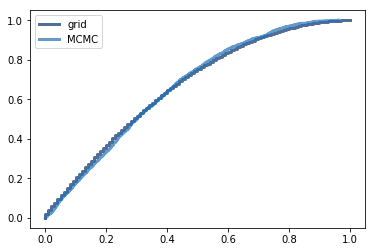

In [23]:
# Check the prior marginals
with model:
    prior_trace = pm.sample(1000)
    
thinkplot.Cdf(prior.Marginal(0).MakeCdf(), label='grid')
thinkplot.Cdf(Cdf(prior_trace['T']), label='MCMC')
thinkplot.Config()

In [24]:
# Add the data
with model:
    pm.Categorical('observed', p=[L, T, B], observed=observed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T, L]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1538.27draws/s]


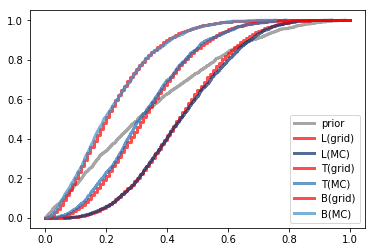

In [25]:
# Find the posteriors
with model:
    trace = pm.sample(1000)
    
thinkplot.Cdf(Cdf(prior_trace['L']), label='prior', color='grey')
thinkplot.Cdf(suite.Marginal(0).MakeCdf(), label='L(grid)', color='red')
thinkplot.Cdf(Cdf(trace['L']), label='L(MC)')
thinkplot.Cdf(suite.Marginal(1).MakeCdf(), label='T(grid)', color='red')
thinkplot.Cdf(Cdf(trace['T']), label='T(MC)')
thinkplot.Cdf(suite.Marginal(2).MakeCdf(), label='B(grid)', color='red')
thinkplot.Cdf(Cdf(1 - trace['L'] - trace['T']), label='B(MC)')
thinkplot.Config()

In [35]:
def plot_trace_cdfs(trace):
    rows = trace['ps'].transpose()

    cdf_lion = Cdf(rows[0])
    cdf_tiger = Cdf(rows[1])
    cdf_bear = Cdf(rows[2])

    thinkplot.Cdf(cdf_lion, label='lions')
    thinkplot.Cdf(cdf_tiger, label='tigers')
    thinkplot.Cdf(cdf_bear, label='bears')
    
    thinkplot.decorate(xlabel='Prevalence',
                       ylabel='CDF')

In [27]:
#plot_trace_cdfs(trace)

In [28]:
#pmf = Pmf(trace['xs'][0])
#thinkplot.Hist(pmf)

In [36]:
with model:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, start=start, step=step, tune=1000)

logp = -6.2383, ||grad|| = 0.5: 100%|██████████| 6/6 [00:00<00:00, 1256.41it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [T]
>Metropolis: [L]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:00<00:00, 4764.08draws/s]
The number of effective samples is smaller than 25% for some parameters.


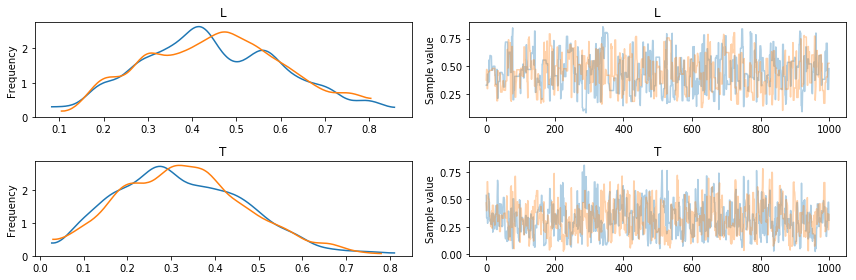

In [37]:
pm.traceplot(trace);

In [38]:
plot_trace_cdfs(trace)

KeyError: 'Unknown variable ps'

In [ ]:
thinkplot.PrePlot(6)
plot_marginal_cdfs(dirichlet)
plot_trace_cdfs(trace)